# A really simple way to annotate cell types in a single cell dataset

This is using an AI chat system (ChatGPT or any other) to annotate an anndata object with celltype info.
Depending on the AI model used the results will likely differ vastly, but the current Chatgpt version did well for my cells.

I am using function from one of my github repos:

In [5]:
from ScanpyAutoAnalyzer import functions
import anndata
import scanpy
import scvelo as scv

In [64]:
?functions.preprocess

Signature:
functions.preprocess(
    adata,
    drop_ribosomal=True,
    drop_mitochondrial=True,
    minUMI=1000,
    minFeatures=100,
    n_highly_significant=300,
    dimensions=2,
    resolution=1,
    mt_regex='^[Mm][Tt]-',
    rp_regex='^R[pP][SsLl]',
)
Docstring:
This function provides a complete, ready-to-use preprocessing workflow for 
single-cell RNA-seq analysis using Scanpy and Scvelo. It is designed to enforce 
reasonable defaults that reflect personal best practices, while still allowing 
customization where appropriate.

This function:
1. Calculates quality-control (QC) metrics.
2. Filters out ribosomal and/or mitochondrial genes (if requested).
3. Removes low-quality cells (based on minUMI and minFeatures thresholds).
4. Normalizes counts and removes lowly expressed genes.
5. Identifies highly variable genes.
6. Computes neighbors, UMAP embeddings, and Leiden clusters.

Parameters
----------
adata : AnnData
    The annotated data matrix of shape n_obs × n_vars. 
    Sho

In [29]:
adata = scanpy.datasets.pbmc3k()        # 3k PBMCs from 10x Genomics
adata = functions.preprocess( adata, resolution = 1.5, n_highly_significant=1000 )

[INFO] QC metrics calculated.
[INFO] Retained 32619 genes after MT/RP filtering.
[INFO] Remaining cells after filtering: 2126
[INFO] Normalization & log-transformation done.
[INFO] Selected 1000 highly variable genes.
[INFO] UMAP computed with 2 dimensions.
[INFO] Leiden clustering done (resolution=1.5).


In [30]:
adata

AnnData object with n_obs × n_vars = 2126 × 13327
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'geneSum', 'n_genes', 'leiden'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

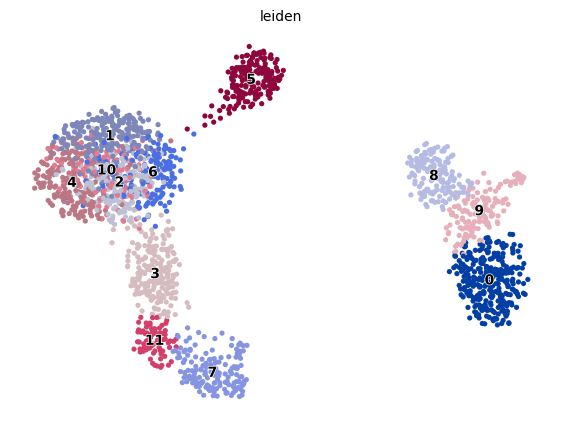

In [31]:
scv.pl.scatter(adata, color=['leiden'], figsize =(7,5), legend_loc='on data')

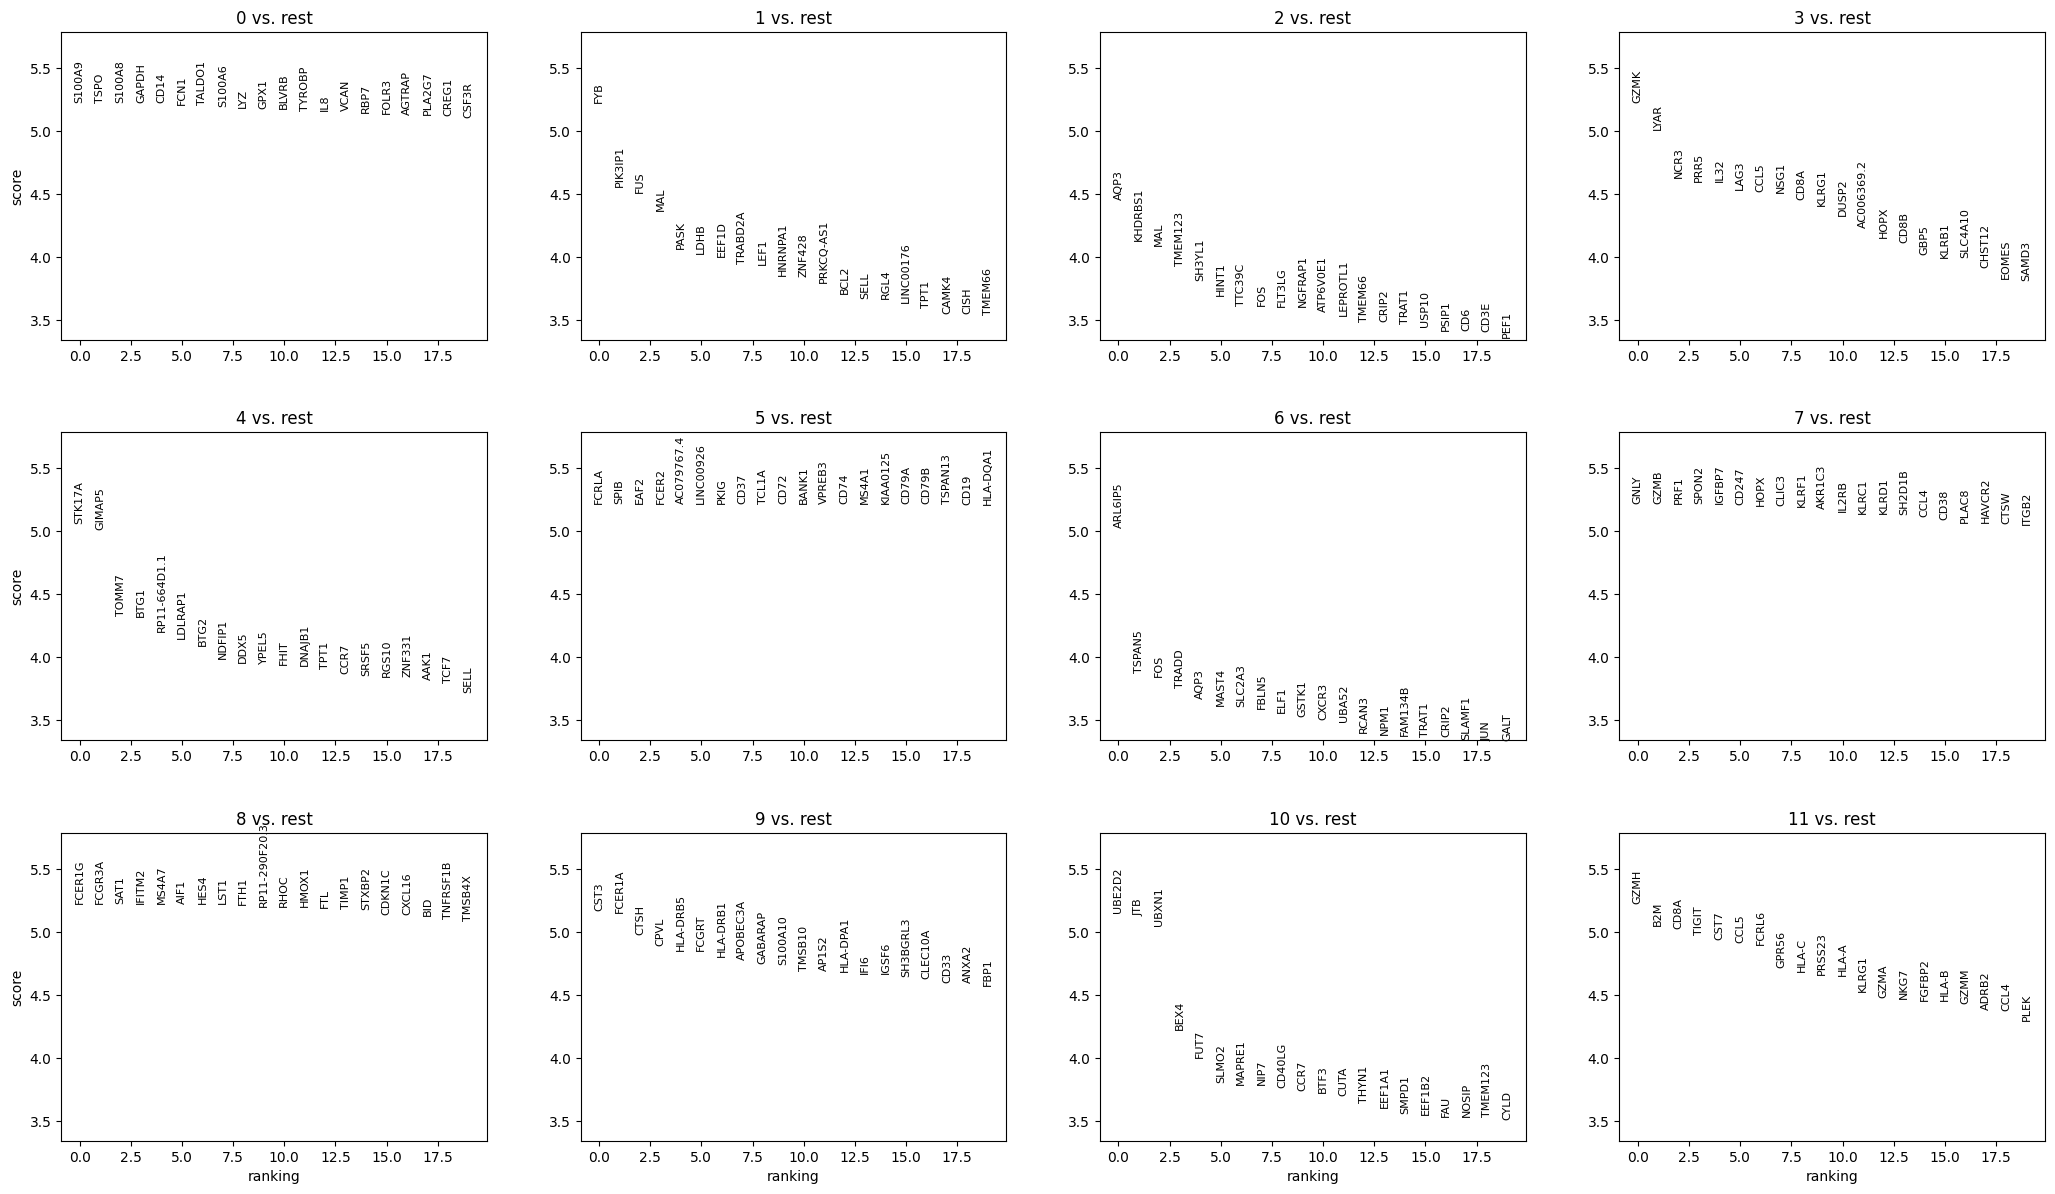

Pseudo-bulk DE analysis complete. Results stored under adata.uns['pseudo_bulk_DE']['leiden_stats'].


In [32]:
functions.write_pseudobulk_stats_tables( adata , "leiden_stats" )

In [33]:
genes = functions.write_top_genes_per_cluster( adata, "leiden_stats", 30 )

Top 30 genes per cluster have been written to top_genes_per_cluster.csv


You now upload this table to e.g. ChatGPT and ask something like:

"I would need help with my leiden clusters, I have differential genes for my dataset and give you the top 30 per cluster. Can you get me the most likely cell type for that, please as Python Dictionary with string leiden cluster and then string cell type. Thank you! ***paste table here***"

In [34]:
ai_cell_types = {
    "0": "Monocyte / Inflammatory monocyte",  # S100A8, S100A9, CD14, LYZ, FCN1
    "1": "Naïve / Helper T cell",             # LEF1, IL7R, SELL, FYB
    "2": "T cell (likely effector or memory)",# CD3E, CD6, TRAT1, FLT3LG
    "3": "Cytotoxic T cell / NK-like cell",   # GZMK, CD8A, CD8B, KLRG1, CCL5
    "4": "Naïve / Central memory T cell",    # CCR7, LEF1, SELL, TCF7
    "5": "B cell / Follicular B cell",        # CD19, CD79A/B, MS4A1, POU2AF1, FCRLA
    "6": "T cell / Activated or memory T cell", # TRAT1, TCF7, SLAMF1, CD6
    "7": "NK cell / Cytotoxic lymphocyte",    # GNLY, GZMB, PRF1, NKG7, KLRD1
    "8": "Monocyte / Macrophage",             # FCER1G, FCGR3A, AIF1, LST1, CEBPB
    "9": "Dendritic cell / Antigen-presenting cell", # HLA-DRB1, HLA-DPA1, CLEC10A, CD33
    "10": "T cell (likely naive or helper)",  # CD40LG, CCR7, other T-cell markers
    "11": "Cytotoxic T cell / NK-like cell",  # GZMH, GZMA, PRF1, CD8A, NKG7
}

In [35]:
adata = functions.add_cell_types_from_dict( adata, 'leiden', ai_cell_types, "AI_CellTypes")

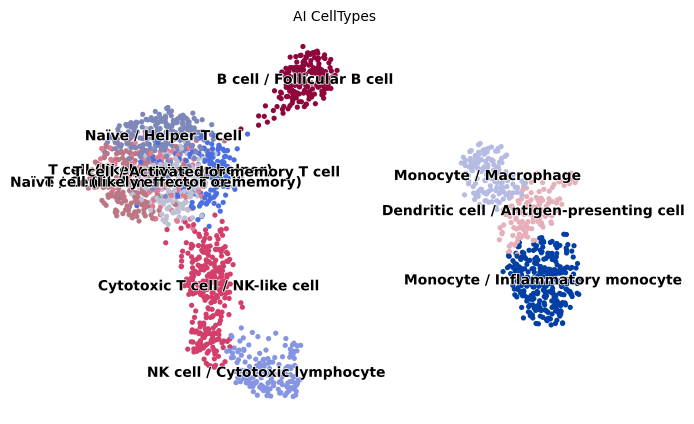

In [36]:
scv.pl.scatter(adata, color=['AI_CellTypes'], figsize =(7,5), legend_loc='on data')

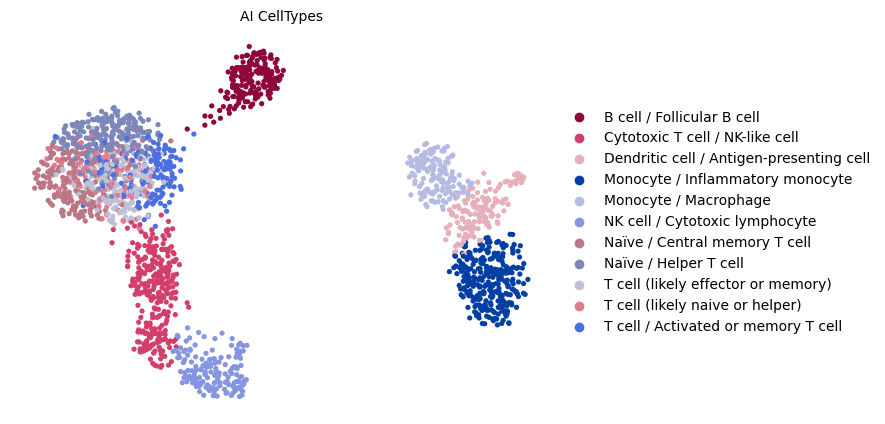

In [37]:
scv.pl.scatter(adata, color=['AI_CellTypes'], figsize =(7,5), legend_loc='right side')

# These cell types are not exactly perfect.

But that might change in the future. The data might also not be exactly perfect

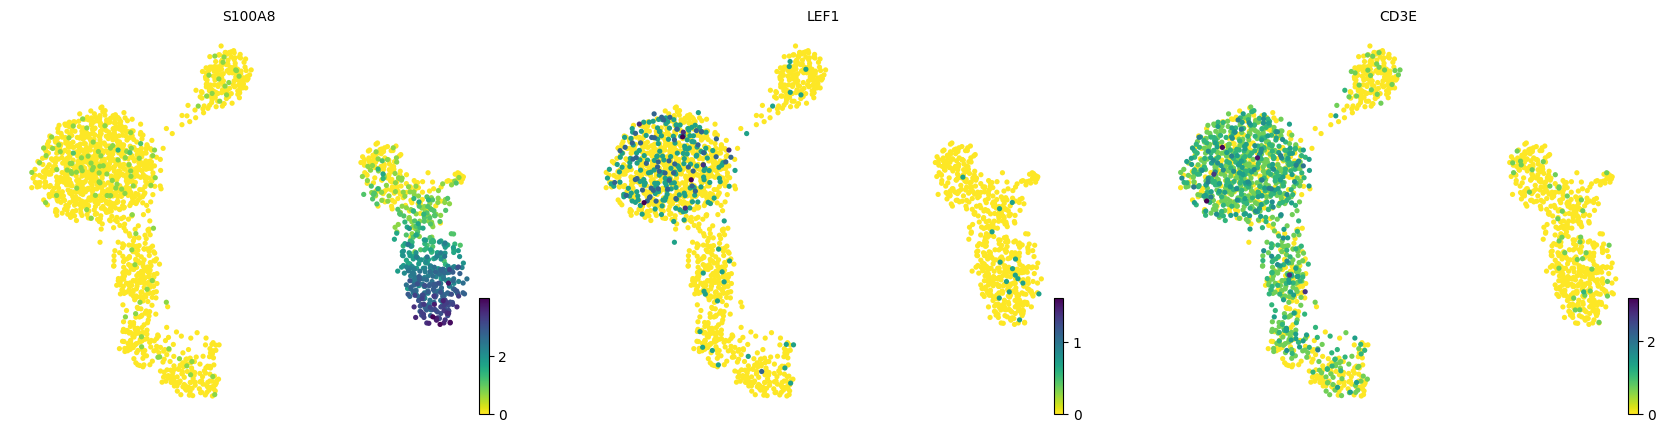

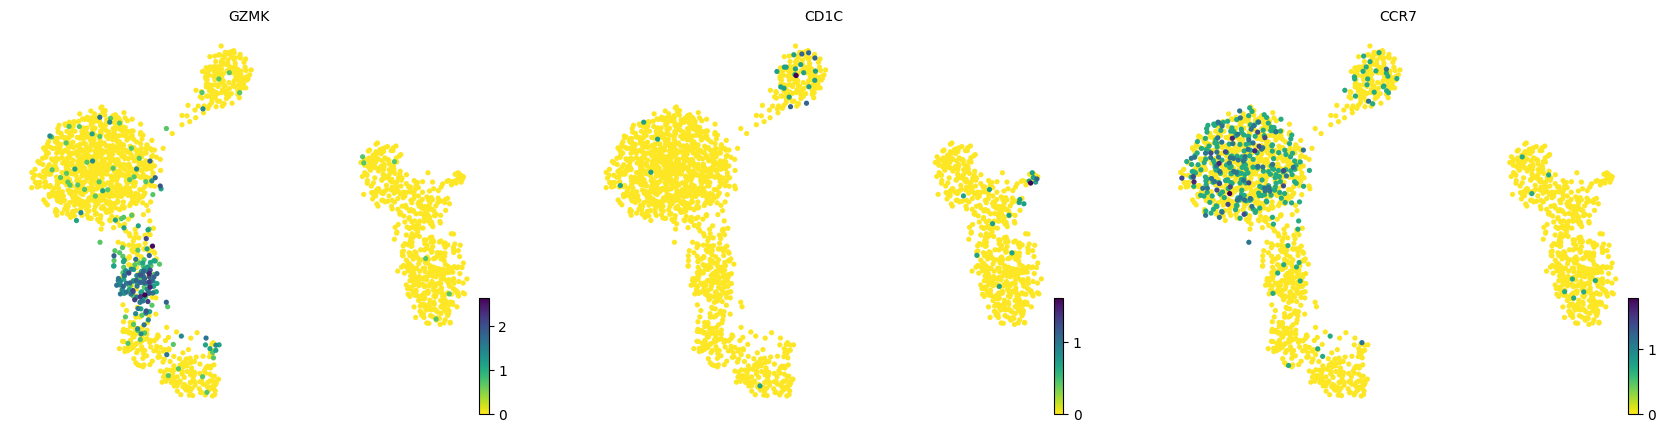

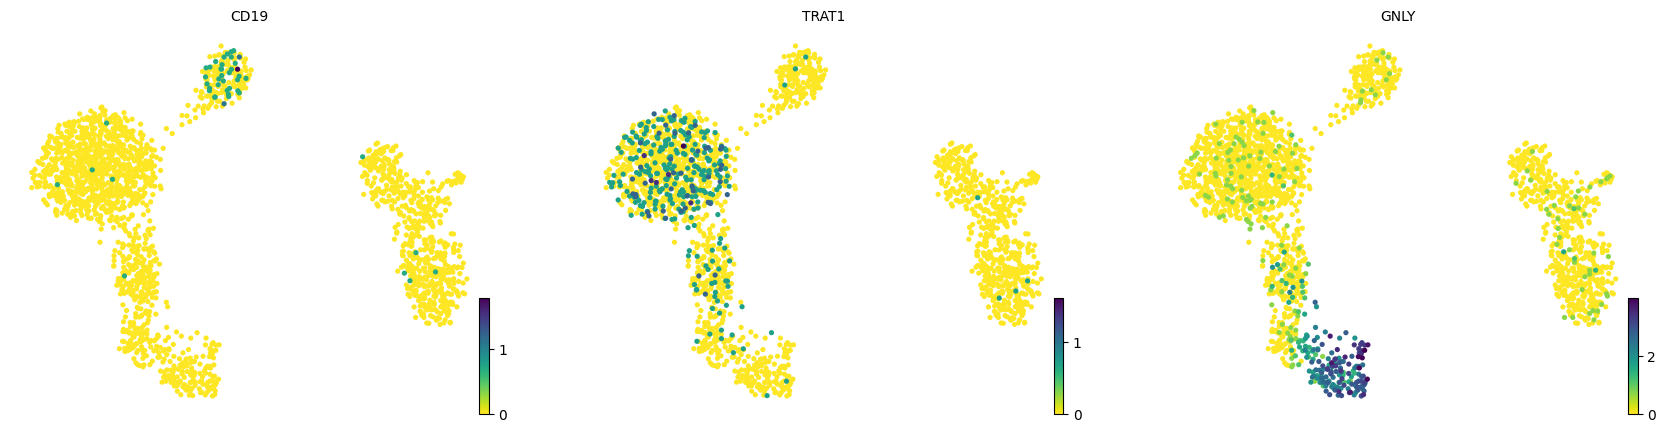

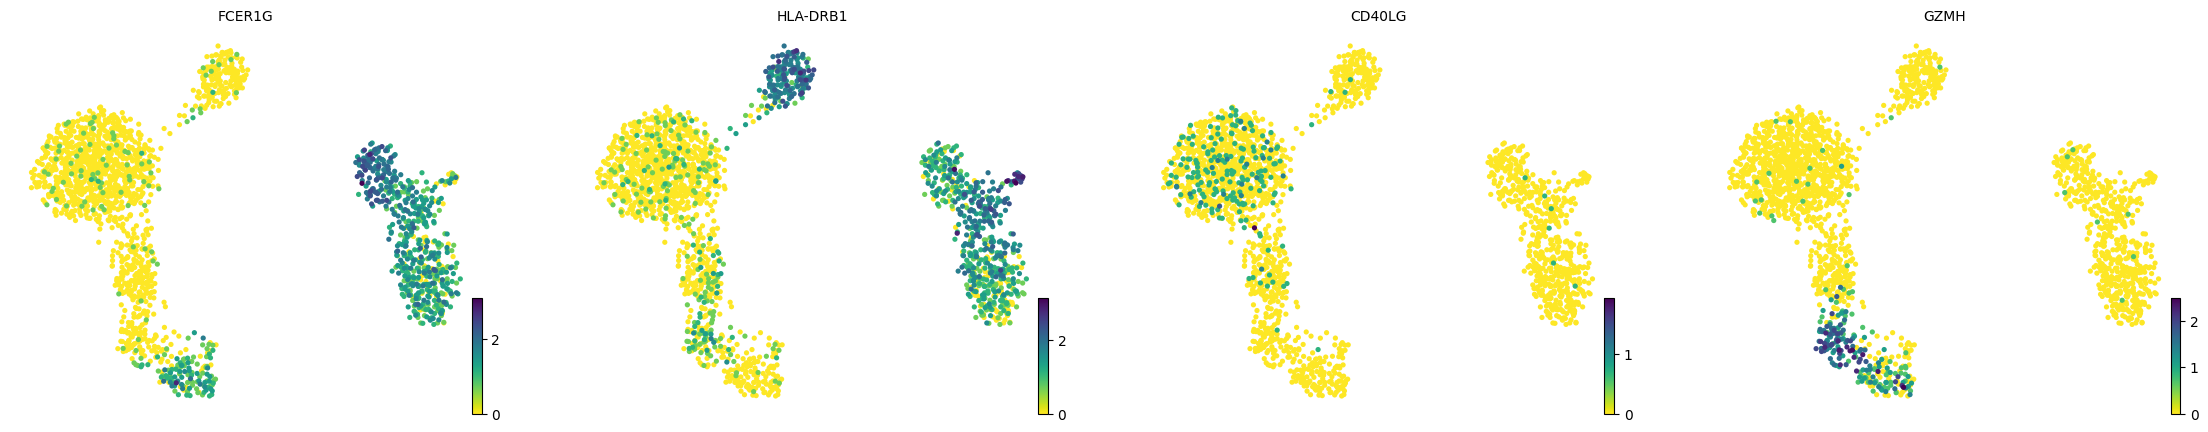

In [63]:
scv.pl.scatter(adata, color=['S100A8', 'LEF1', "CD3E",], figsize =(7,5), legend_loc='right side', color_map="viridis_r")
scv.pl.scatter(adata, color=['GZMK', 'CD1C', 'CCR7', ], figsize =(7,5), legend_loc='right side', color_map="viridis_r")
scv.pl.scatter(adata, color=['CD19', 'TRAT1', 'GNLY', ], figsize =(7,5), legend_loc='right side', color_map="viridis_r")
scv.pl.scatter(adata, color=['FCER1G', 'HLA-DRB1', 'CD40LG', 'GZMH' ], figsize =(7,5), legend_loc='right side', color_map="viridis_r")